## ARIMA and SARIMAX

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [4]:
df_gl = pd.read_csv("./GLB.Ts+dSST.csv", header = 1, index_col = 0)
df_nh = pd.read_csv("./NH.Ts+dSST.csv", header = 1, index_col = 0)
df_sh = pd.read_csv("./SH.Ts+dSST.csv", header = 1, index_col = 0)
df_zon = pd.read_csv("./ZonAnn.Ts+dSST.csv", index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: './GLB.Ts+dSST.csv'

In [115]:
df_gl.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1880,-0.18,-0.24,-0.09,-0.16,-0.10,-0.22,-0.18,-0.10,-0.14,-.23,-.22,-.18,-.17,***,***,-0.12,-0.17,-.20
1881,-0.19,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.16,-.22,-.19,-.07,-.09,-.10,-.17,0.05,-0.08,-.19
1882,0.16,0.14,0.04,-0.17,-0.15,-0.23,-0.17,-0.07,-0.14,-.24,-.17,-.36,-.11,-.09,.08,-0.09,-0.16,-.18
1883,-0.29,-0.37,-0.13,-0.19,-0.19,-0.08,-0.08,-0.15,-0.22,-.12,-.25,-.12,-.18,-.20,-.34,-0.17,-0.10,-.19
1884,-0.13,-0.09,-0.37,-0.40,-0.34,-0.36,-0.31,-0.29,-0.28,-.25,-.34,-.31,-.29,-.27,-.11,-0.37,-0.32,-.29


In [116]:
columns_to_convert = ['Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'SON']
df_gl[columns_to_convert] = df_gl[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Assuming 'Year' is the column containing years, convert it to a datetime index
df_gl.index = pd.to_datetime(df_gl.index, format='%Y')

In [117]:
temperature_anomaly = df_gl['J-D']
temperature_anomaly = pd.Series(
    temperature_anomaly.values, index=pd.date_range("1-1-1880", periods=len(temperature_anomaly), freq="Y"), name="temp_anomaly"
)
temperature_anomaly = temperature_anomaly[:143]
temperature_anomaly

1880-12-31   -0.17
1881-12-31   -0.09
1882-12-31   -0.11
1883-12-31   -0.18
1884-12-31   -0.29
              ... 
2018-12-31    0.85
2019-12-31    0.97
2020-12-31    1.01
2021-12-31    0.84
2022-12-31    0.89
Freq: A-DEC, Name: temp_anomaly, Length: 143, dtype: float64

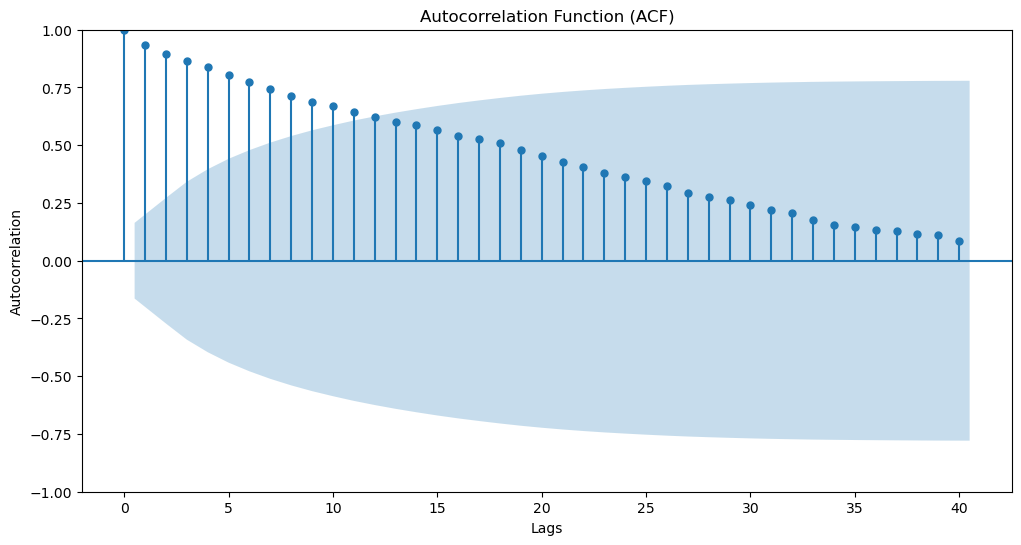

In [118]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(temperature_anomaly, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

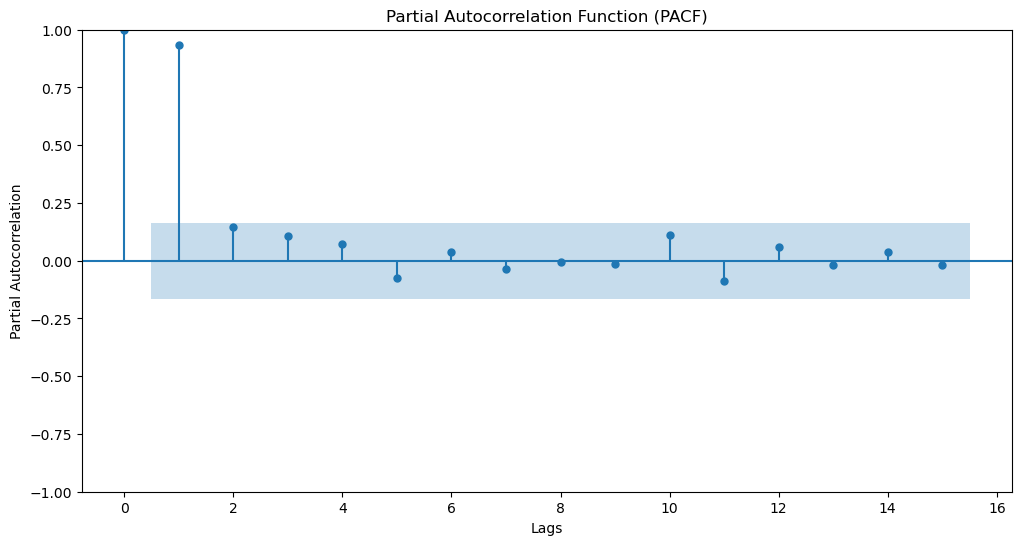

In [119]:
plt.figure(figsize=(12, 6))
plot_pacf(temperature_anomaly, lags=15, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [120]:
result = adfuller (temperature_anomaly.dropna())
print('p-value: ', result[1])

p-value:  0.9942809316737001


In [121]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(temperature_anomaly, autolag='AIC')

# Extracting test statistics and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Display the results
print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis. The time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The time series is likely non-stationary.')


ADF Statistic: 1.001422191182046
P-value: 0.9942809316737001
Fail to reject the null hypothesis. The time series is likely non-stationary.


In [122]:
# Perform ADF test for differencing
temperature_anomaly_diff = temperature_anomaly.diff(i).dropna()

    # Perform ADF test
adf_result_diff = adfuller(temperature_anomaly_diff, autolag='AIC')

    # Extracting test statistics and p-value
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]

    # Display the results
print(f'ADF Statistic (after {i} differencing): {adf_statistic_diff}')
print(f'P-value (after {i} differencing): {p_value_diff}')

    # Interpret the results
if p_value_diff <= 0.05:
    print(f'Reject the null hypothesis for 1st differencing. The differenced time series is likely stationary.')
else:
    print(f'Fail to reject the null hypothesis for 1st differencing. The differenced time series is likely non-stationary.')

ADF Statistic (after 3 differencing): -3.2975285788670954
P-value (after 3 differencing): 0.014989309169541136
Reject the null hypothesis for 1st differencing. The differenced time series is likely stationary.


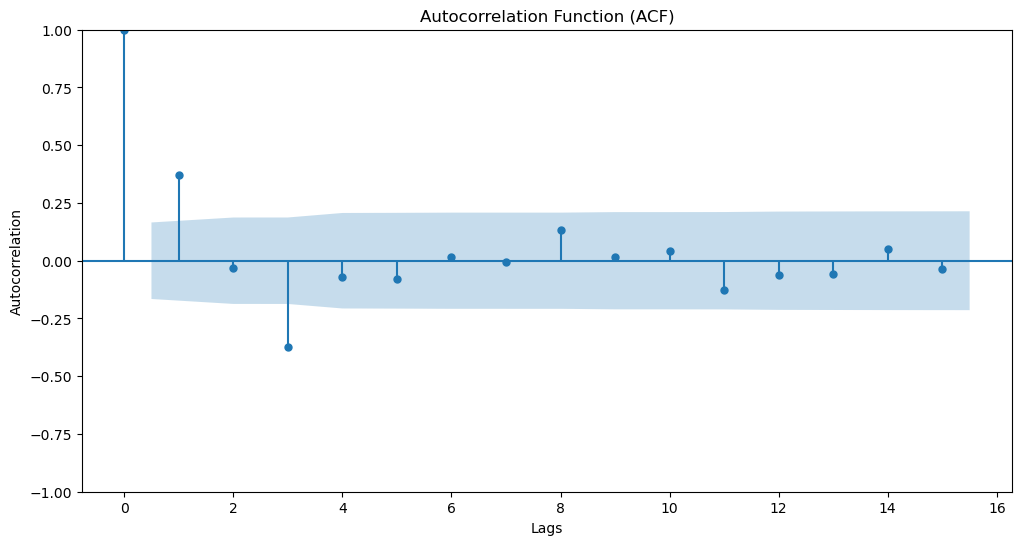

In [123]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(temperature_anomaly_diff, lags=15, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

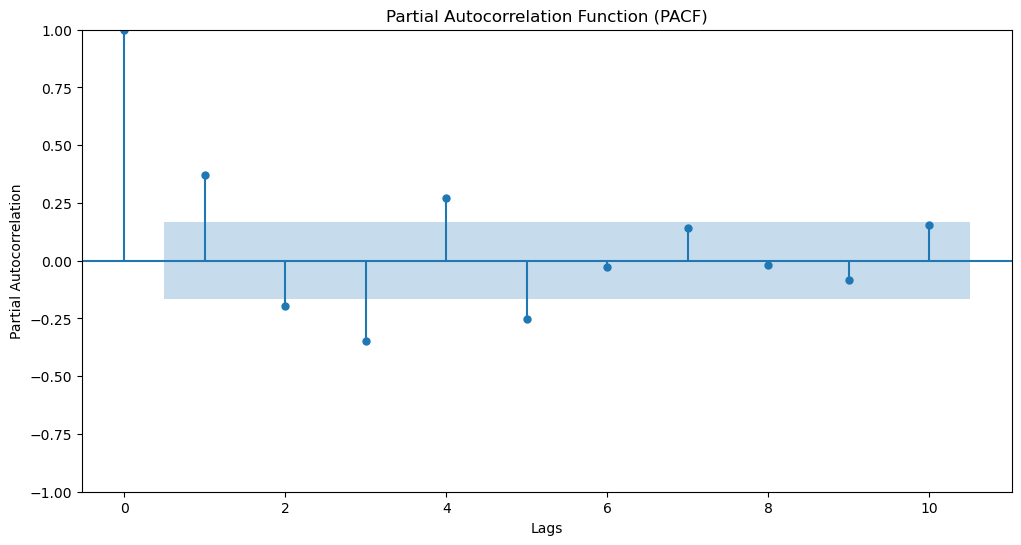

In [124]:
plt.figure(figsize=(12, 6))
plot_pacf(temperature_anomaly_diff, lags=10, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
# p = 1; d = 1; q = 1; ARIMA(3,1,2)(0,0,0)[0]; Best model:  ARIMA(5,1,1)(0,0,0)[0] 

arima_model = ARIMA(temperature_anomaly_diff, order=(1,1,1))
model = arima_model.fit()
print(model.summary())

In [ ]:
arima_model2 = ARIMA(temperature_anomaly_diff, order=(3,1,2))
model2 = arima_model2.fit()
print(model2.summary())

In [ ]:
arima_model3 = ARIMA(temperature_anomaly_diff, order=(5,1,1))
model3 = arima_model3.fit()
print(model3.summary())

In [ ]:
# Forecast future values
forecast_steps = 25
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff, label='Observed', color='blue')
plt.plot(pd.date_range("2023-12-31", periods=forecast_steps, freq="Y"), forecast, label='Forecast', color='red')
# Optionally, plot confidence intervals if available
# plt.fill_between(pd.date_range("2023-12-31", periods=forecast_steps, freq="Y"), conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.1)
plt.title('ARIMA Forecast of Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

In [ ]:
# Split the data into training and test sets
train_size = int(len(temperature_anomaly_diff) * 0.8)
train, test = temperature_anomaly_diff[:train_size], temperature_anomaly_diff[train_size:]

# Fit the ARIMA model on the training set
arima_model = ARIMA(train, order=(1, 1, 1))
model = arima_model.fit()

# Forecast on the test set
forecast_steps = len(test)
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Calculate Mean Squared Error (MSE) as an evaluation metric
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


In [ ]:
# Split the data into training and test sets
train_size = int(len(temperature_anomaly_diff) * 0.8)
train, test = temperature_anomaly_diff[:train_size], temperature_anomaly_diff[train_size:]

# Fit the ARIMA model on the training set
arima_model = ARIMA(train, order=(5, 1, 1))
model = arima_model.fit()

# Forecast on the test set
forecast_steps = len(test)
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Calculate Mean Squared Error (MSE) as an evaluation metric
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

In [ ]:
# Split the data into training and test sets
train_size = int(len(temperature_anomaly_diff) * 0.8)
train, test = temperature_anomaly_diff[:train_size], temperature_anomaly_diff[train_size:]

# Fit the ARIMA model on the training set
arima_model = ARIMA(train, order=(3, 1, 2))
model = arima_model.fit()

# Forecast on the test set
forecast_steps = len(test)
forecast = model.forecast(steps=forecast_steps, alpha=0.05)

# Calculate Mean Squared Error (MSE) as an evaluation metric
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

In [ ]:
import pmdarima as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and test sets
train_size = int(len(temperature_anomaly_diff) * 0.8)
train, test = temperature_anomaly_diff[:train_size], temperature_anomaly_diff[train_size:]

# Perform grid search for ARIMA parameters
best_score, best_order = float("inf"), None

# Define the ranges for p, d, and q
p_values = d_values = q_values = range(0, 6)

# Iterate through all possible combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Fit ARIMA model
                model = pm.auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False, d=1, trace=False)
                # Make predictions on the test set
                predictions = model.predict(len(test))
                # Evaluate the model using Mean Squared Error
                mse = mean_squared_error(test, predictions)
                if mse < best_score:
                    best_score, best_order = mse, order
            except:
                continue

# Fit the final ARIMA model with the best parameters
final_model = pm.auto_arima(temperature_anomaly_diff, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False, d=1)
final_model.fit(temperature_anomaly_diff)

# Make predictions on the test set
final_predictions = final_model.predict(len(test))

# Evaluate the final model
final_mse = mean_squared_error(test, final_predictions)
print(f"Best ARIMA Order: {best_order}")
print(f"Final Model MSE on Test Set: {final_mse}")


In [ ]:
# Plot the actual vs. predicted values on the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, final_predictions, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation (Test Set)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Forecast future values till 2050
forecast_steps = 2050 - len(temperature_anomaly_diff)
future_forecast = final_model.predict(steps=forecast_steps)

# Plot the forecasted values till 2050
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff.index, temperature_anomaly_diff, label='Historical Data', color='blue')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='green')
plt.title('ARIMA Future Forecast (Till 2050)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


In [ ]:
# Plot the actual vs. predicted values on the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, final_predictions, label='Predicted', color='red')
plt.title('ARIMA Model Evaluation (Test Set)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Forecast future values till 2050
forecast_steps = 2050 - len(temperature_anomaly_diff)
future_forecast = model.predict(steps=forecast_steps)

# Plot the forecasted values till 2050
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff.index, temperature_anomaly_diff, label='Historical Data', color='blue')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='green')
plt.title('ARIMA Future Forecast (Till 2050)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/raunak17/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


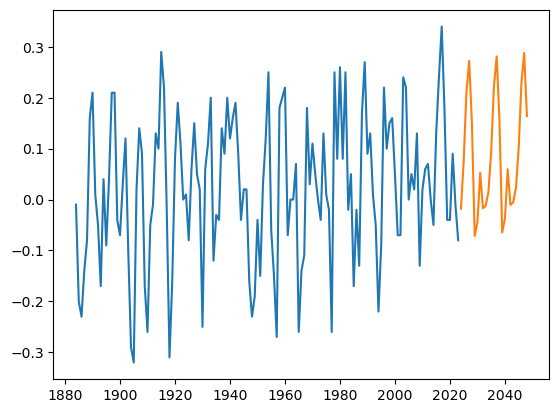

In [125]:
stlf = STLForecast(temperature_anomaly_diff, ARIMA, period = 10 ,model_kwargs=dict(order=(1, 1, 1), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(25)
plt.plot(temperature_anomaly_diff)
plt.plot(forecast)
plt.show()

In [ ]:
# Fit STLForecast model
stlf = STLForecast(train, ARIMA, period=10, model_kwargs=dict(order=(1, 1, 1), trend="t"))
stlf_res = stlf.fit()

# Forecast on the test set
forecast = stlf_res.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Temperature Anomaly')
plt.plot(forecast, label='Predicted Temperature Anomaly', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Temperature Anomaly')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.ylim(-1, 1)
plt.show()

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

In [ ]:
print(stlf_res.summary())

In [ ]:
# Fit STLForecast model
stlf = STLForecast(train, ARIMA, period=10, model_kwargs=dict(order=(3, 1, 2), trend="t"))
stlf_res = stlf.fit()

# Forecast on the test set
forecast = stlf_res.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Temperature Anomaly')
plt.plot(forecast, label='Predicted Temperature Anomaly', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Temperature Anomaly')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.ylim(-1, 1)
plt.show()

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

In [ ]:
# Define your non-seasonal ARIMA order
p, d, q = 1, 1, 1

# Define ranges for seasonal parameters
seasonal_p_values = range(0, 3)
seasonal_d_values = range(0, 3)
seasonal_q_values = range(0, 3)
s_values = [12]  # Assuming monthly data

seasonal_order = list(product(seasonal_p_values, seasonal_d_values, seasonal_q_values, s_values))

best_score, best_params = float("inf"), None

for order in seasonal_order:
    try:
        # Fit SARIMA model with pre-defined non-seasonal parameters
        model = SARIMAX(train, order=(p, d, q), seasonal_order=order)
        results = model.fit(disp=False)
        # Make predictions on the validation set
        predictions = results.get_forecast(steps=len(test))
        mse = mean_squared_error(test, predictions.predicted_mean)
        if mse < best_score:
            best_score, best_params = mse, order
    except:
        continue

print(f"Non-Seasonal ARIMA Order: ({p}, {d}, {q})")
print(f"Best Seasonal Order: {best_params}")


In [ ]:
final_model = SARIMAX(train, order=(p, d, q), seasonal_order=best_params)
final_results = final_model.fit(disp=False)
print(final_results.summary())

In [ ]:
# Make predictions on the test set
predictions = final_results.get_forecast(steps=len(test))

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(test, predictions.predicted_mean)
print(f"Final SARIMA Model MSE on Test Set: {mse}")

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions.predicted_mean, label='Predicted', color='red')
plt.title('Actual vs Predicted Temperature Anomaly')
plt.legend()
plt.ylim(-1, 1)
plt.show()


In [ ]:
sarimax_model = SARIMAX(temperature_anomaly_diff, order=(p, d, q), seasonal_order=best_params)
sarimax_results = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_results.forecast(25)
plt.plot(temperature_anomaly_diff)
plt.plot(sarimax_forecast)
plt.show()




In [ ]:
# Define the number of steps for future predictions
future_steps = 30  # Adjust this number based on how many future time points you want to predict

# Make future predictions
future_forecast = results.get_forecast(steps=len(test) + future_steps)

# Plot the actual data, predictions, and future forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(future_forecast.predicted_mean, label='SARIMAX Predictions', color='red')
plt.title('SARIMAX Forecast and Future Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.legend()
plt.show()


In [ ]:
# Fit STLForecast model on the entire dataset
stlf_full = STLForecast(temperature_anomaly_diff, ARIMA, period=10, model_kwargs=dict(order=(1, 1, 1), trend="t"))
stlf_res_full = stlf_full.fit()

# Forecast future values
forecast_steps = 25  # or any desired number of steps into the future
forecast_full, stderr_full, conf_int_full = stlf_res_full.forecast(steps=forecast_steps)

# Combine the forecasted components to get the overall forecast
forecast_full_combined = forecast_full['trend'] + forecast_full['seasonal'] + forecast_full['resid']

# Extend the index for the forecasted values
extended_index = pd.date_range(start=temperature_anomaly_diff.index[-1], periods=forecast_steps + 1, freq="Y")[1:]
forecast_full_combined.index = extended_index

# Plot the forecast
plt.plot(temperature_anomaly_diff, label='Historical Data')
plt.plot(forecast_full_combined, label='Forecasted Temperature Anomaly', linestyle='dashed')
plt.legend()
plt.title('Historical and Forecasted Temperature Anomaly (STL ARIMA)')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.ylim(-2, 2)  # Adjust the y-axis limits as needed
plt.show()


In [ ]:
# Forecast future values
forecast_steps = 25
forecast_full = stlf_res_full.forecast(steps=forecast_steps)

# Combine the forecasted components to get the overall forecast
forecast_full_combined = forecast_full['trend'] + forecast_full['seasonal'] + forecast_full['resid']

# Extend the index for the forecasted values
extended_index = pd.date_range(start=temperature_anomaly_diff.index[-1], periods=forecast_steps + 1, freq="Y")[1:]
forecast_full_combined.index = extended_index

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(temperature_anomaly_diff, label='Historical Data')
plt.plot(forecast_full_combined, label='Forecasted Temperature Anomaly', linestyle='dashed')
plt.legend()
plt.title('Historical and Forecasted Temperature Anomaly (STL ARIMA)')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.ylim(-2, 2)
plt.show()
